In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import random
import math
import pandas as pd
import seaborn as sns
import keras 

from keras import preprocessing, optimizers, utils, layers, models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping

from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptionv3_preprocess_input
#from keras.applications.vgg16 import VGG16
#from keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input

%matplotlib inline

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

Using TensorFlow backend.


In [2]:
image_dir = '/Users/steffensiltamiesgiessing/Desktop/mushroom_data/Image_classification_AiExam/Mushroom_classification/Mushrooms'

g_type_list = [x.split('/') [-1] for x in glob.glob(os.path.join(image_dir,'[A-Z]*'))]
print(g_type_list)

['Agaricus', 'Cortinarius', 'Russula', 'Suillus', 'Entoloma', 'Hygrocybe', 'Amanita', 'Boletus', 'Lactarius']


In [3]:
num_classes = len(g_type_list)
print('{:<20}'.format('Mushroom Genuses:')+'{:>90}'.format(', '.join(g_type_list)))
print('{:<40}'.format('Number of Mushroom Genuses/Classes:')+'{:>70}'.format('{:2n}'.format(num_classes)))

image_size = 299 #299 for InceptionV3, 224 for ResNet50 and VGG16
batch_size = 32
print('-'*110)
print('{:<40}'.format('Input Image:')+'{:>70}'.format('{:3n} x {:3n} x {:1n}'.format(*[image_size, image_size, 3])))
print('{:<40}'.format('Batch Size:')+'{:>70}'.format('{:2n}'.format(batch_size)))

n_images = len(glob.glob(os.path.join(image_dir, '*/*jpg')))
train_val_split = 0.25
n_val = int(n_images*train_val_split)
n_train = n_images - n_val
print('-'*110)
print('{:<40}'.format('Total Number of Training Images:')+'{:>70}'.format('{:3n}'.format(n_train)))
print('{:<40}'.format('Total Number of Validation Images:')+'{:>70}'.format('{:3n}'.format(n_val)))

Mushroom Genuses:    Agaricus, Cortinarius, Russula, Suillus, Entoloma, Hygrocybe, Amanita, Boletus, Lactarius
Number of Mushroom Genuses/Classes:                                                                          9
--------------------------------------------------------------------------------------------------------------
Input Image:                                                                                     299 x 299 x 3
Batch Size:                                                                                                 32
--------------------------------------------------------------------------------------------------------------
Total Number of Training Images:                                                                          5036
Total Number of Validation Images:                                                                        1678


In [4]:
inceptionv3_weights = '../input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
base = InceptionV3(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling='avg')

2021-11-21 14:02:43.893769: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-21 14:02:43.894843: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [5]:
for layer in base.layers:
    layer.trainable = False

X = base.output
X = GlobalAveragePooling2D()(X)
X = BatchNormalization()(X)

X = Dense(128, activation='sigmoid')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(128, activation=None)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
X = Dropout(0.3)(X)

X = Dense(num_classes, activation=None)(X)
X = BatchNormalization()(X)
Y = Activation('softmax')(X)

 

model = models.Model(inputs=base.input, outputs=Y)


In [6]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [7]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
idg = preprocessing.image.ImageDataGenerator(preprocessing_function=inceptionv3_preprocess_input, validation_split=train_val_split)

train_generator = idg.flow_from_directory(
        image_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True)

val_generator = idg.flow_from_directory(
        image_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=True)


Found 5038 images belonging to 9 classes.
Found 1676 images belonging to 9 classes.


In [9]:
print(val_generator.class_indices)


{'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}


/Users/steffensiltamiesgiessing/Desktop/mushroom_data/Image_classification_AiExam/Mushroom_classification/Mushrooms 353
/Users/steffensiltamiesgiessing/Desktop/mushroom_data/Image_classification_AiExam/Mushroom_classification/Mushrooms 836
/Users/steffensiltamiesgiessing/Desktop/mushroom_data/Image_classification_AiExam/Mushroom_classification/Mushrooms 1148
/Users/steffensiltamiesgiessing/Desktop/mushroom_data/Image_classification_AiExam/Mushroom_classification/Mushrooms 311
/Users/steffensiltamiesgiessing/Desktop/mushroom_data/Image_classification_AiExam/Mushroom_classification/Mushrooms 364
/Users/steffensiltamiesgiessing/Desktop/mushroom_data/Image_classification_AiExam/Mushroom_classification/Mushrooms 316
/Users/steffensiltamiesgiessing/Desktop/mushroom_data/Image_classification_AiExam/Mushroom_classification/Mushrooms 750
/Users/steffensiltamiesgiessing/Desktop/mushroom_data/Image_classification_AiExam/Mushroom_classification/Mushrooms 1073
/Users/steffensiltamiesgiessing/Deskto

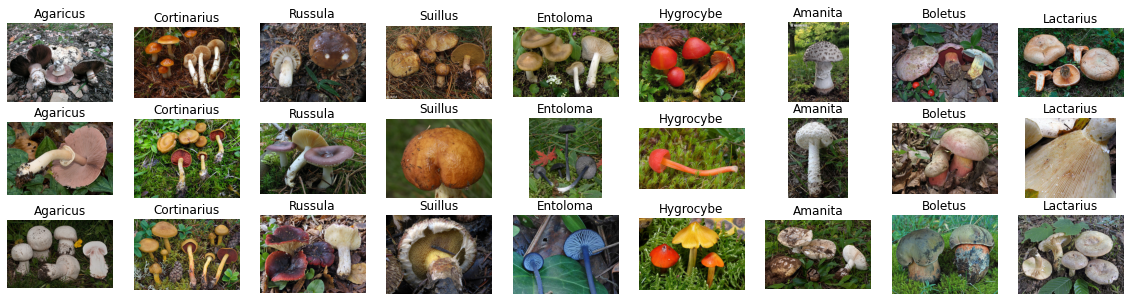

In [10]:
num_per_genus = 3
random_images = []
random_images_labels = []

for g in g_type_list:
    g_img_list = glob.glob(os.path.join(image_dir, g+'/*jpg'))
    num_img = len(g_img_list)
    print(image_dir ,num_img)
    rand_img_ind = np.random.choice(np.arange(0, num_img), size=num_per_genus, replace=False)
    random_images += [g_img_list[i] for i in rand_img_ind]
    random_images_labels += [g]*num_per_genus

f, ax = plt.subplots(num_per_genus, num_classes, figsize=(20,5))
for i, sample in enumerate(random_images):
    ax[i%num_per_genus, i//num_per_genus].imshow(plt.imread(sample))
    ax[i%num_per_genus, i//num_per_genus].axis('off')
    ax[i%num_per_genus, i//num_per_genus].set_title(random_images_labels[i])

plt.show()    

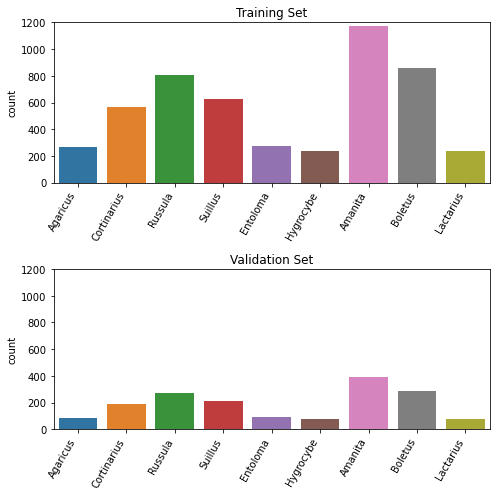

In [11]:
training_df = pd.DataFrame(train_generator.classes, columns=['classes'])
val_df = pd.DataFrame(val_generator.classes, columns=['classes'])

plt.figure(1, figsize=(7, 7))

for i in range(2):
    if i == 0:
        df = training_df
        ax = plt.subplot(211)

    else:
        df = val_df
        ax = plt.subplot(212)

    s = sns.countplot(x='classes', data=df, ax=ax)
    _ = plt.xticks(s.get_xticks(), g_type_list, rotation=60, ha='right')
    s.set_xlabel(None)
    s.set_ylim(0, 1200)
    if i == 0:
        _ = s.set_title('Training Set')
    else:
        _ = s.set_title('Validation Set')

plt.tight_layout()

In [12]:
# from keras.preprocessing.image import ImageDataGenerator
# from keras.preprocessing import image

# datagen = ImageDataGenerator(
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# fnames = glob.glob(os.path.join(image_dir, '*/*jpg'))


# img_path = fnames[4]

# img = image.load_img(img_path, target_size=(299,299))

# x = image.img_to_array(img)

# x = x.reshape((1,) + x.shape)

# i = 0
# #from keras.preprocessing import image

# for batch in datagen.flow(x, batch_size=1):
#     plt.figure(i)
#     imgplot = plt.imshow(image.img_to_array(batch[0]))
#     i += 1
#     if 1 % 4 == 0:
#         break
# plt.show
    

In [13]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint('weights.best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor = 'val_loss', patience = 5)

history = model.fit_generator(train_generator,\
                                  steps_per_epoch=math.ceil(n_train/batch_size),\
                                  epochs=10,\
                                  validation_data=val_generator,\
                                  validation_steps=math.ceil(n_val/batch_size),\
                                  callbacks=[checkpoint, earlystop])

Epoch 1/10
158/158 [==============================] - 3221s 20s/step - loss: 1.5982 - accuracy: 0.4684 - val_loss: 1.7338 - val_accuracy: 0.4535

Epoch 00001: val_accuracy improved from -inf to 0.45346, saving model to weights.best.hdf5
Epoch 2/10
158/158 [==============================] - 3225s 20s/step - loss: 1.1554 - accuracy: 0.6548 - val_loss: 1.6674 - val_accuracy: 0.4421

Epoch 00002: val_accuracy did not improve from 0.45346
Epoch 3/10
158/158 [==============================] - 3227s 20s/step - loss: 1.0026 - accuracy: 0.7100 - val_loss: 1.4635 - val_accuracy: 0.4475

Epoch 00003: val_accuracy did not improve from 0.45346
Epoch 4/10
158/158 [==============================] - 3174s 20s/step - loss: 0.8566 - accuracy: 0.7596 - val_loss: 1.6706 - val_accuracy: 0.4791

Epoch 00004: val_accuracy improved from 0.45346 to 0.47912, saving model to weights.best.hdf5
Epoch 5/10
158/158 [==============================] - 3201s 20s/step - loss: 0.7798 - accuracy: 0.7809 - val_loss: 2.2841

In [14]:
model.save('mushroom_inceptionv3.h5')

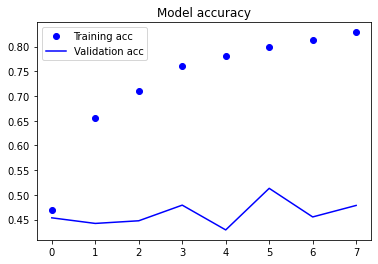

<Figure size 432x288 with 0 Axes>

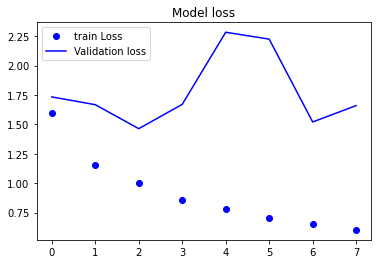

In [15]:
# Plot training & validation accuracy values

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Model accuracy')
#plt.ylabel('Accuracy')
#plt.xlabel('Epoch')
plt.legend()
plt.figure()

plt.show()

# Plot training & validation loss values
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs, loss, 'bo', label='train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Model loss')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
plt.legend()
plt.show()

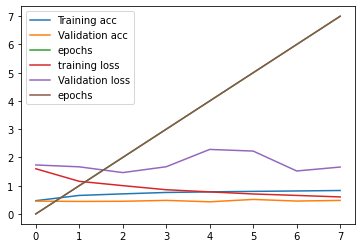

In [16]:
plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')

plt.plot(epochs, label='epochs')

plt.legend()
_=plt.ylim()

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='Validation loss')
plt.plot(epochs, label='epochs')
plt.legend()
_=plt.ylim()

